# Poisson Regression -  tools on islands, part 1

##### Keywords: poisson distribution, poisson regression, glm, centering, counterfactual plot, regression, interaction-term, oceanic tools, parameter correlation

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

From Mcelreath:

>The island societies of Oceania provide a natural experiment in technological evolution. Different historical island populations possessed tool kits of different size. These kits include fish hooks, axes, boats, hand plows, and many other types of tools. A number of theories predict that larger populations will both develop and sustain more complex tool kits. So the natural variation in population size induced by natural variation in island size in Oceania provides a natural experiment to test these ideas. It's also suggested that contact rates among populations effectively increase population size, as it's relevant to technological evolution. So variation in contact rates among Oceanic societies is also relevant. (McElreath 313)

![](images/islands.png)

## Setting up the model and data

Some points to take into account:

- sample size is not  umber of rows, after all this is a count model
- the data is small, so we will need regularizing to avoid overfitting
- outcome will be `total_tools` which we will model as proportional to `log(population)` as theory says it depends on order of magnitude
- number of tools incereases with `contact` rate
- we will, over multiple attempts, be testing the idea that the impact of population on tool counts is increased by high `contact`. This is an example of an **interaction**. Specifically this is a **positive** interaction between `log(population)` and `contact`.

In [2]:
df=pd.read_csv("data/islands.csv", sep=';')
df

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


In [3]:
df['logpop']=np.log(df.population)
df['clevel']=(df.contact=='high')*1
df

,culture,population,contact,total_tools,mean_TU,logpop,clevel
0,Malekula,1100,low,13,3.2,7.003065,0
1,Tikopia,1500,low,22,4.7,7.313220,0
2,Santa Cruz,3600,low,24,4.0,8.188689,0
3,Yap,4791,high,43,5.0,8.474494,1
4,Lau Fiji,7400,high,33,5.0,8.909235,1
5,Trobriand,8000,high,19,4.0,8.987197,1
6,Chuuk,9200,high,40,3.8,9.126959,1
7,Manus,13000,low,28,6.6,9.472705,0
8,Tonga,17500,high,55,5.4,9.769956,1
9,Hawaii,275000,low,71,6.6,12.524526,0


Lets write down the model we plan to fit.

### M1

$$
\begin{eqnarray}
T_i & \sim & Poisson(\lambda_i)\\
log(\lambda_i) & = & \alpha + \beta_P log(P_i) + \beta_C C_i + \beta_{PC} C_i log(P_i)\\
\alpha & \sim & N(0,100)\\
\beta_P & \sim & N(0,1)\\
\beta_C & \sim & N(0,1)\\
\beta_{PC} & \sim & N(0,1)
\end{eqnarray}
$$

The $\beta$s have strongly regularizing priors on them, because the sample is small, while the $\alpha$ prior is essentially a flat prior.

## Implementation in pymc

In [4]:
import theano.tensor as t
with pm.Model() as m1:
    betap = pm.Normal("betap", 0, 1)
    betac = pm.Normal("betac", 0, 1)
    betapc = pm.Normal("betapc", 0, 1)
    alpha = pm.Normal("alpha", 0, 100)
    loglam = alpha + betap*df.logpop + betac*df.clevel + betapc*df.clevel*df.logpop
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)
    

In [5]:
with m1:
    trace=pm.sample(10000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, betapc, betac, betap]
Sampling 2 chains: 100%|██████████| 21000/21000 [01:17<00:00, 269.30draws/s]
The acceptance probability does not match the target. It is 0.88659413662, but should be close to 0.8. Try to increase the number of tuning steps.


In [6]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betap,0.264372,0.035345,0.000443,0.194924,0.333177,6225.835834,1.000744
betac,-0.083529,0.838570,0.009645,-1.700037,1.597633,6954.452047,1.000067
betapc,0.042019,0.091893,0.001062,-0.147786,0.214488,6987.273344,1.000076
alpha,0.934902,0.366691,0.004492,0.208745,1.645146,6253.602039,1.000709


//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


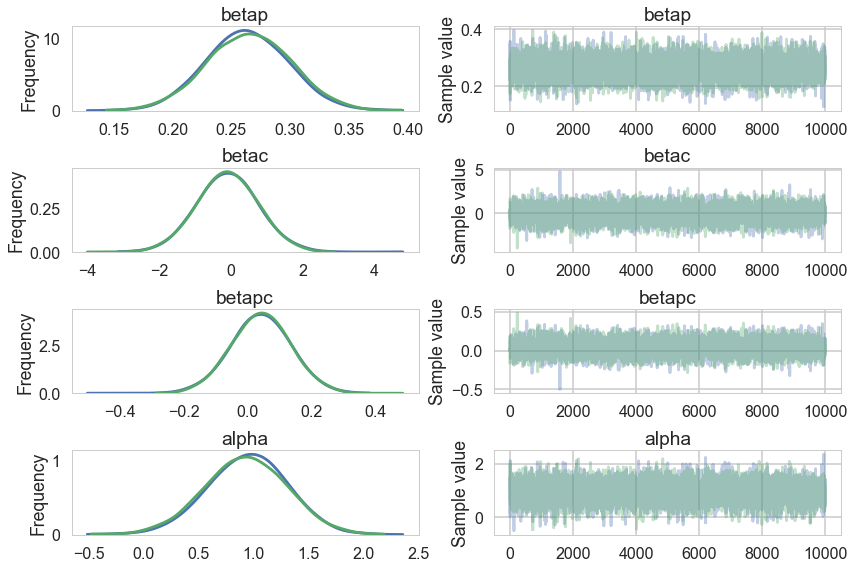

In [7]:
pm.traceplot(trace);

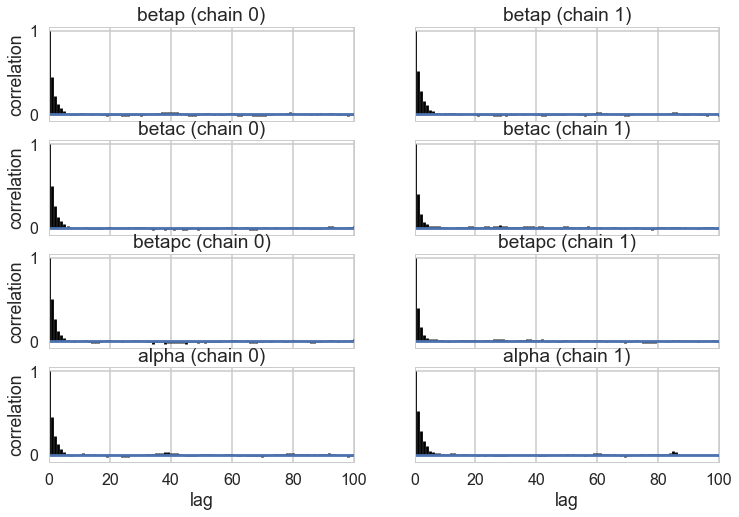

In [8]:
pm.autocorrplot(trace);

Our traces an autocorrelations look pretty good. `pymc3` does quick work on the model

### Posteriors

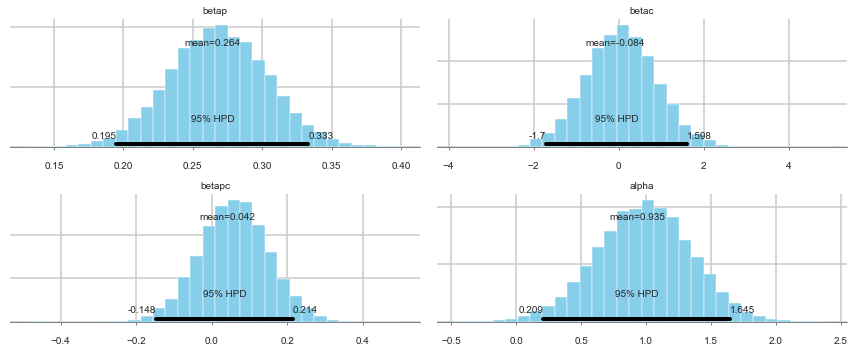

In [9]:
pm.plot_posterior(trace);

Looking at the posteriors reveals something interesting. The posterior for $\beta_p$ is, as expected from theory, showing a positive effect. The posterior is fairly tightly constrained. The posteriors for $\beta_c$ and $\beta_{pc}$ both overlap 0 substantially, and seem comparatively poorly constrained.

At this point you might be willing to say that there is no substantial effect of contact rate, directly or through the interaction.

You would be wrong.

### Posterior check with counterfactual predictions.

Lets get $\lambda$ traces for high-contact and low contact

In [10]:
lamlow = lambda logpop: trace['alpha']+trace['betap']*logpop
lamhigh = lambda logpop: trace['alpha']+(trace['betap'] + trace['betapc'])*logpop + trace['betac'] 

Now let us see what happens at an intermediate log(pop) of 8:

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


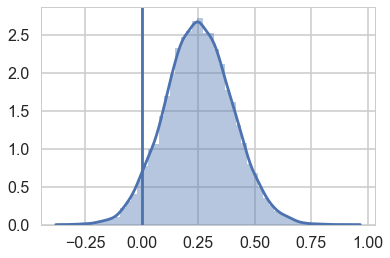

In [11]:
sns.distplot(lamhigh(8) - lamlow(8));
plt.axvline(0);

We can see evidence of a fairly strong positive effect of contact in this "counterfactual posterior", with most of the weight above 0.

So what happened?

### Posterior scatter plots

We make posterior scatter plots and this give us the answer.

In [12]:
def postscat(trace, thevars):
    d={}
    for v in thevars:
        d[v] = trace.get_values(v)
    df = pd.DataFrame.from_dict(d)
    return sns.pairplot(df)

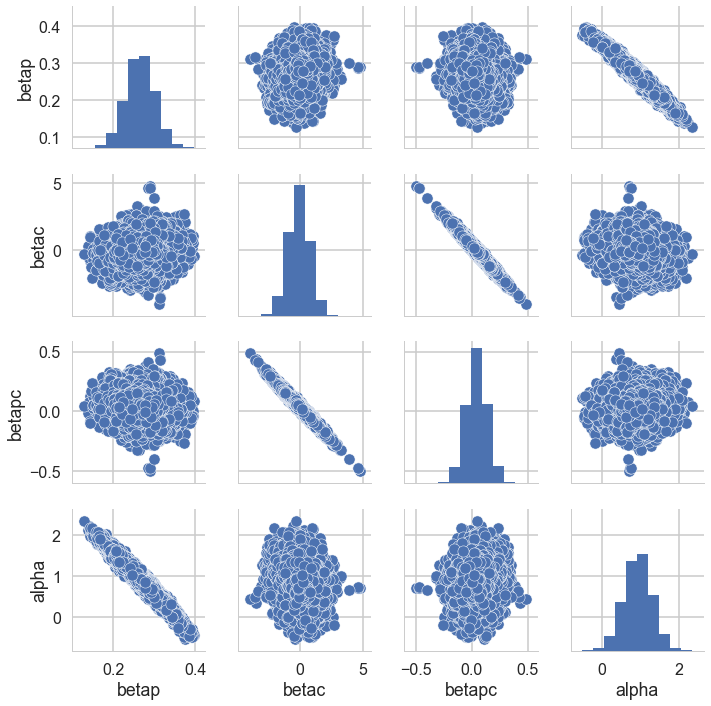

In [13]:
postscat(trace,trace.varnames)

Look at the very strong negative correlations between $\alpha$ and $\beta_p$, and the very strong ones between $\beta_c$ and $\beta_{pc}$. The latter is the cause for the 0-overlaps. When $\beta_c$ is high, $\beta_{pc}$ must be low, and vice-versa. As a result, its not enough to observe just the marginal uncertainty of each parameter; you must look at the joint uncertainty of the correlated variables.

You would have seen that this might be a problem if you looked at $n_{eff}$:

In [14]:
pm.effective_n(trace)

{'alpha': 6253.6020387847238,
 'betac': 6954.4520465741789,
 'betap': 6225.8358335534804,
 'betapc': 6987.2733444159694}

## Fixing by centering

As usual, centering the log-population fixes things:

In [15]:
df.logpop_c = df.logpop - df.logpop.mean()

//anaconda/envs/py3l/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [16]:
with pm.Model() as m1c:
    betap = pm.Normal("betap", 0, 1)
    betac = pm.Normal("betac", 0, 1)
    betapc = pm.Normal("betapc", 0, 1)
    alpha = pm.Normal("alpha", 0, 100)
    loglam = alpha + betap*df.logpop_c + betac*df.clevel + betapc*df.clevel*df.logpop_c
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)

In [17]:
with m1c:
    trace1c = pm.sample(10000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, betapc, betac, betap]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:16<00:00, 1284.28draws/s]


In [18]:
pm.effective_n(trace1c)

{'alpha': 13059.09068128995,
 'betac': 13486.057010456128,
 'betap': 14787.07665103561,
 'betapc': 14659.70637220611}

In [19]:
pm.summary(trace1c)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betap,0.263160,0.035343,0.000270,0.191687,0.330985,14787.076651,0.999950
betac,0.285020,0.116811,0.000988,0.051495,0.510018,13486.057010,0.999965
betapc,0.064929,0.168961,0.001466,-0.270487,0.394762,14659.706372,1.000043
alpha,3.311022,0.089226,0.000771,3.140614,3.491820,13059.090681,0.999956


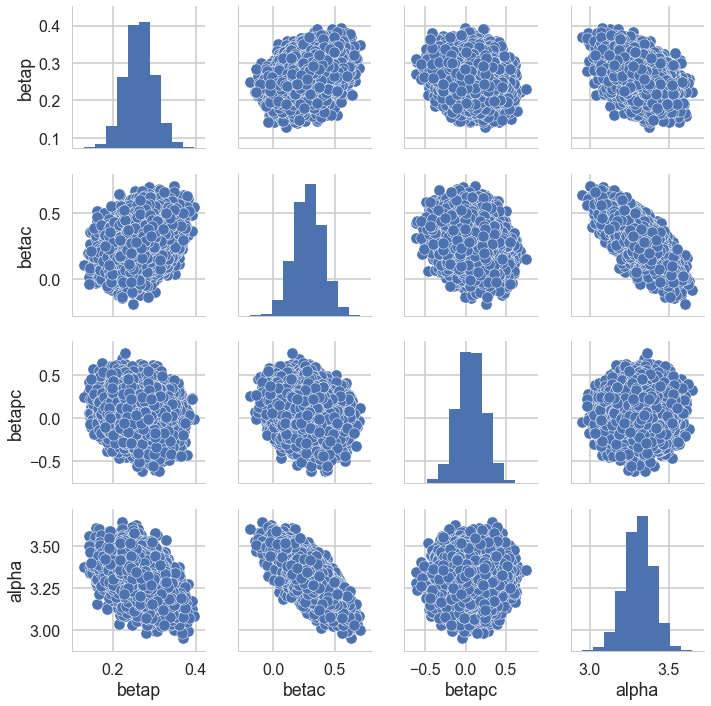

In [20]:
postscat(trace1c,trace1c.varnames)

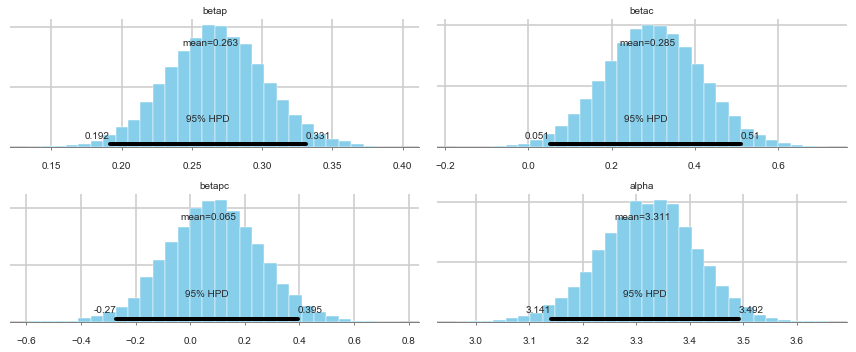

In [21]:
pm.plot_posterior(trace1c);

How do we decide whether the interaction is significant or not? We'll use model comparison to achieve this!